In [584]:
import pickle
import numpy as np
import PIL.Image
import itertools
from IPython.core.display import Image, display
import scipy.ndimage
import random
import matplotlib.pylab as plt
import tqdm
import math
%matplotlib inline

# Загружаем датасет

In [585]:
with open('./hw_1_train.pickle', 'rb') as f:
    train = pickle.load(f)

with open('./hw_1_test_no_lables.pickle', 'rb') as f:
    test_no_lables = pickle.load(f)

labels, data = np.asfarray(train['labels']) , np.asfarray(train['data'])

In [586]:
# Show i'th image
def show_image(img):
    plt.imshow(img.reshape(28,28))

In [587]:
# Normalizing and classification -1/1
def pixel_norm(x):
    for i,img in enumerate(x):
        mean = np.mean(img, axis=0)
        std = np.std(img, axis=0)
        x[i] = (img - mean)/std
    return x

def classification(y):
    for i,label in enumerate(y):
        y[i]=1 if label==6 else -1
    return y

data = pixel_norm(data)
#data = data / np.float(255)
labels = classification(labels)

# Создание модели

In [588]:
# k-fold Cross Validation Scheme with shuffling
'''k-fold must be 'None' or 2,3..'''

def cross_validation(data, labels, k_fold=None):
    global x_train, y_train
    data_set = np.insert(data, 0, labels, axis=1) # Insert labels(y) in each image(x) row
    random.shuffle(data_set)
    if k_fold != None:
        global x_valid, y_valid 
        train = np.asfarray([x for i, x in enumerate(data_set) if i % k_fold != 1])
        valid = np.asfarray([x for i, x in enumerate(data_set) if i % k_fold == 1])
        y_train, x_train = train[:, 0], train[:, np.r_[1:train.shape[1]]] 
        y_valid, x_valid = valid[:, 0], valid[:, np.r_[1:train.shape[1]]]
        print("Training images:", x_train.shape[0])
        print("Validation images:", x_valid.shape[0])
    else:
        train = np.asfarray(data_set)
        y_train, x_train = train[:, 0], train[:, np.r_[1:train.shape[1]]]
        print("Validation images:", x_train.shape[0])

# Обучаем модель

In [589]:
np.random.seed(11)
w = np.random.normal(scale=0.001, size = data.shape[1])

# Loss gradient
def grad(x, y, w):
    return (-1)*y*x/(1 + np.exp(y*np.dot(w.T, x))) + reg_param*w

# Logloss calculation
def logloss(x, y, w):
    buf_loss = 0
    for i in range(y.shape[0]):
        buf_loss += np.log(1 + np.exp(-y[i]*np.dot(w.T, x[i])))
    return buf_loss/y.shape[0]

# Accuracy calculation
def accuracy(x, y, w):
    n_true = 0
    for i in range(y.shape[0]):
        p = 1/(1+np.exp(-np.dot(w.T, x[i])))
        if p > 0.5:
            y_predicted = 1
        else:
            y_predicted = -1
        if y_predicted == y[i]:
            n_true += 1
    return n_true/y.shape[0]

# Learning epoch
def launch_train(w):   
    for epoch in tqdm.tqdm_notebook(range(batch)):
        j = np.random.randint(0, x_train.shape[0])
        w -= learn_rate*grad(x_train[j], y_train[j], w)
        
        if (epoch % btch) == 0:
            tr_loss.append(logloss(x_train, y_train, w))        
            te_loss.append(logloss(x_valid, y_valid, w))
            tr_acc.append(accuracy(x_train, y_train, w))
            te_acc.append(accuracy(x_valid, y_valid, w))

In [590]:
# Launch
tr_loss = []
te_loss = []
tr_acc = []
te_acc = []
reg_param = 0
learn_rate = 0.009
batch = 9500
btch = 200

cross_validation(data, labels, k_fold=20)
launch_train(w)

Training images: 9500
Validation images: 500


Test Loss:  0.09231689184292839


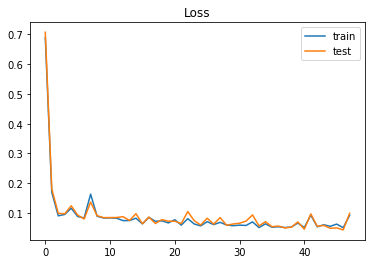

In [591]:
plt.title('Loss')
plt.plot(tr_loss, label='train')
plt.plot(te_loss, label='test')
plt.legend()
print("Test Loss: ", tr_loss[-1])

Test Accuracy:  0.9691578947368421


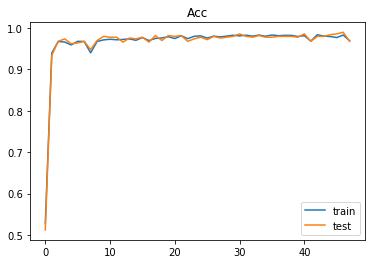

In [592]:
plt.title('Acc')
plt.plot(tr_acc, label='train')
plt.plot(te_acc, label='test')
plt.legend()
print("Test Accuracy: ", tr_acc[-1])

Вероятность того, что это 5 -  0.9999999982790051 
Вероятность того, что это 6 -  1.720994945141405e-09
0.03746936821044145


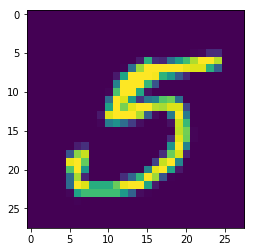

In [593]:
def predict(x): 
    return 1 / (1 + np.exp(-np.dot(w, x)))

p_valid = np.zeros((x_valid.shape[0]))
for i in range(x_valid.shape[0]):
    p_valid[i] = predict(x_valid[i])

k = 0
print("Вероятность того, что это 5 - ", 1 - p_valid[k], "\nВероятность того, что это 6 - ", p_valid[k])

def lgs(true_label, p):
    if true_label == 1:
        return -np.log(p)
    else:
        return -np.log(1 - p)

loss = 0
for i in range(x_valid.shape[0]):
    loss += lgs(y_valid[i], p_valid[i])  
    
print(loss/y_valid.shape[0])
show_image(x_valid[k])
loss = 0

# Оцениваем результат

Обязательно отрисуйте 2 графика:
- loss на обучающем и тестовом множесте
- % правильно классифицированных примеров на тестовом и обучающем множестве

# Сохраняем данные для кагла

https://www.kaggle.com/t/513ea517806348848dc78c4f41d44528

Результат записывается в простой текстовый файл. Первая строчка "Id,Prediction", далее для каждого примера из валидационного множества записывается его Id (порядковый номер, с нуля) и вероятность принадлежности к классу '6', например '123,0.12'.

Важно соблюдать тот же порядок следования элементов, что и в наборе данных. Нумерация id с 0

In [594]:
X = np.asfarray(test_no_lables['data'])
#X = X / 255
X = pixel_norm(X)

# compute Y_pred
Y_pred = np.zeros(X.shape[0], dtype=float)
for i in range(X.shape[0]):
    Y_pred[i] = predict(X[i])    

#with open('solution2.csv', 'w') as fout:
    print("Id,Prediction", file=fout)
    for i in range(X.shape[0]):
        print(i, Y_pred[i], sep=',', file=fout)

k = 0
show_image(X[k])
print(Y_pred[k])

ValueError: I/O operation on closed file.

# Сдача

1. Регистрируетесь на конкурс https://www.kaggle.com/t/513ea517806348848dc78c4f41d44528 
1. Преодолеваете "Pass level" baseline
1. После того, как вы преодолеете baseline, присылайте ноутбук с решение по адресу **voropaev@corp.mail.ru**

# Внимание
- Тему письма писать в формате "[МИФИ][1] Фамилия"
- Внутри писма прикрепляете файл ноутбука с именем family.ipynb